CryptoKitties have many cattributes, but one of their most important traits is speed.  

Speed determines how often a cat can parent additional kittens, and goes down each time them do so.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('/kaggle/input/how-much-would-you-pay-for-a-fake-cat/train.csv')
test_df = pd.read_csv('/kaggle/input/how-much-would-you-pay-for-a-fake-cat/test.csv')
train_df.head()

,id,price,speed,image
0,7d46fd31038904e2,2.13,Fast (1m),./images/7d46fd31038904e2.png
1,76690b9129b9895c,0.46,Catatonic (1w),./images/76690b9129b9895c.png
2,c5f9966acce22205,10,Swift (2m),./images/c5f9966acce22205.png
3,dfcbc3748fa8e4ba,2,Catatonic (1w),./images/dfcbc3748fa8e4ba.png
4,eefb9c589f2ad43a,1,Snappy (10m),./images/eefb9c589f2ad43a.png


In [3]:
# First let's look at price, the thing we're trying to predict
train_df['price']

0       2.13
1       0.46
2         10
3          2
4          1
        ... 
1995    5.08
1996     0.3
1997    1.44
1998     2.5
1999      40
Name: price, Length: 2000, dtype: object

# Types of Machine Learning
- Supervised Learning: Labeled questions and answers
  - Classification
      - Is it a cat or a dog?
      - Is this word a noun, verb, or adjective?
      - Does this pateint have cancer? (Yes or No)
  - Regression
      - What score will I get on a test?
      - How much will this house sell for?
      - How tall will someone be when they grow up?
- Unsuprvised Learning: Learning some structure about our data (customer segmentation)
- Reinforcement Learning: Learning from interacting with an environment (learning how play chess)

In [4]:
# Our dtype is object, which generally means our data is being interpretted as a string
def clean_price(price_str):
    clean_price_str = price_str.replace(',', '')
    return float(clean_price_str)
clean_price('1,234.1')

1234.1

In [5]:
train_df['clean_price'] = train_df['price'].apply(clean_price)

train_df['clean_price']

0        2.13
1        0.46
2       10.00
3        2.00
4        1.00
        ...  
1995     5.08
1996     0.30
1997     1.44
1998     2.50
1999    40.00
Name: clean_price, Length: 2000, dtype: float64

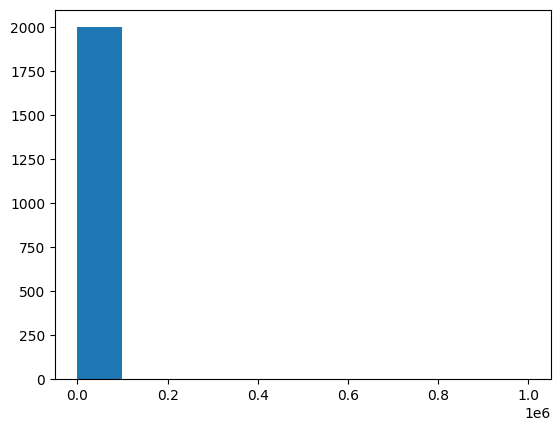

In [6]:
plt.hist(train_df['clean_price'])
plt.show()

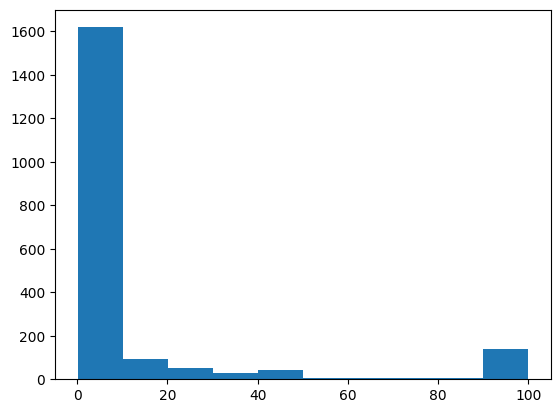

In [7]:
# Our distribution is wildly skew, and the highnest number is O(1M ETH), which is close to $1.5M
# This price seems anomolous, so lets just cap our data
train_df['clean_price'] = train_df['clean_price'].clip(0, 100)

plt.hist(train_df['clean_price'])
plt.show()

In [8]:
train_df['speed'].value_counts()

speed
Fast (1m)         1067
Catatonic (1w)     389
Swift (2m)          97
Swift (5m)          76
Snappy (10m)        52
Brisk (2h)          52
Snappy (30m)        48
Brisk (1h)          42
Plodding (4h)       41
Slow (16h)          36
Plodding (8h)       27
Slow (24h)          27
Sluggish (4d)       26
Sluggish (2d)       20
Name: count, dtype: int64

In [9]:
# Really it's that number we care about, so let's write a function to extract that and normalize it
import re

unit_map = {
    'm': 1,
    'h': 60,
    'd': 60*24,
    'w': 60*24*7,
}

# This function takes a speed string from out dataset
# and returns the number of minutes it represents
def clean_speed(speed_str):
    cooldown_str = re.findall('\((\d+[mhdw])\)', speed_str)[0]
    # At this point `cooldown_str` looks like "24h"
    cooldown_count = int(cooldown_str[:-1])
    cooldown_unit = cooldown_str[-1]
    return cooldown_count * unit_map[cooldown_unit]
    
train_df['clean_speed'] = train_df['speed'].apply(clean_speed)
train_df['clean_speed']

0           1
1       10080
2           2
3       10080
4          10
        ...  
1995        1
1996        2
1997        1
1998        1
1999        1
Name: clean_speed, Length: 2000, dtype: int64

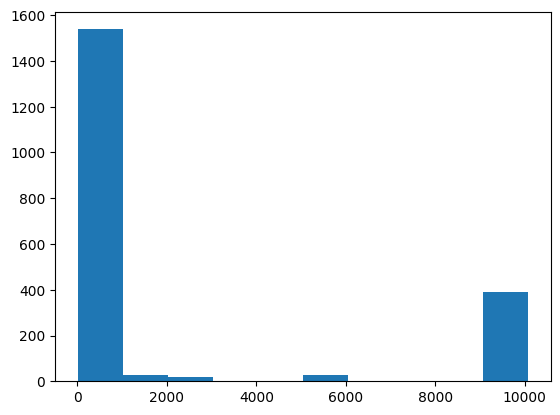

In [10]:
plt.hist(train_df['clean_speed'])
plt.show()

/tmp/ipykernel_20/3163477850.py:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(train_df['clean_speed'], train_df['clean_price'], c=(0, .5, 1, .05), s=100)


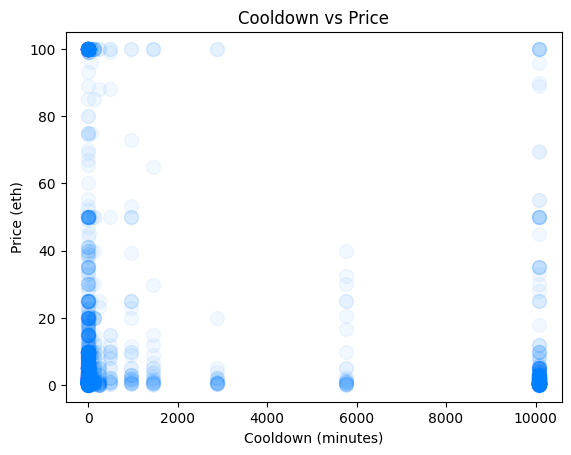

In [11]:
plt.scatter(train_df['clean_speed'], train_df['clean_price'], c=(0, .5, 1, .05), s=100)
plt.title('Cooldown vs Price')
plt.xlabel('Cooldown (minutes)')
plt.ylabel('Price (eth)')
plt.show()

In [12]:
# This graph makes it a little difficult to see whats going on
# One tool we can use to get a sense of the relationship between these things is their correlation coefficient
# If the coefficient is positive and large, this means a higher number in one value is likely to go along with a high number in the other
# If the coefficient is negative and large, it means the opposite: as one value goes up, the other goes down
train_df['clean_speed'].corr(train_df['clean_price'])

-0.11811700478346031

In [13]:
# So we see that slower cats are likely to have lower prices
# A simple model we could build is to say "cats are worth something by default, and are worth a little less for every additional minute they have in cooldown"
def predict_price(cooldown):
    b = 100 # Default price of a cat
    m = -0.01 # The amount the price falls for each minute of cooldown
    return b + (m * cooldown)

train_df['predicted_price'] = train_df['clean_speed'].apply(predict_price)
train_df['predicted_price']

0       99.99
1       -0.80
2       99.98
3       -0.80
4       99.90
        ...  
1995    99.99
1996    99.98
1997    99.99
1998    99.99
1999    99.99
Name: predicted_price, Length: 2000, dtype: float64

/tmp/ipykernel_20/3783585706.py:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(train_df['clean_speed'], train_df['clean_price'], c=(0, .5, 1, .05), s=100)
/tmp/ipykernel_20/3783585706.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(train_df['clean_speed'], train_df['predicted_price'], c=(1, .01, .01, .1), s=10)


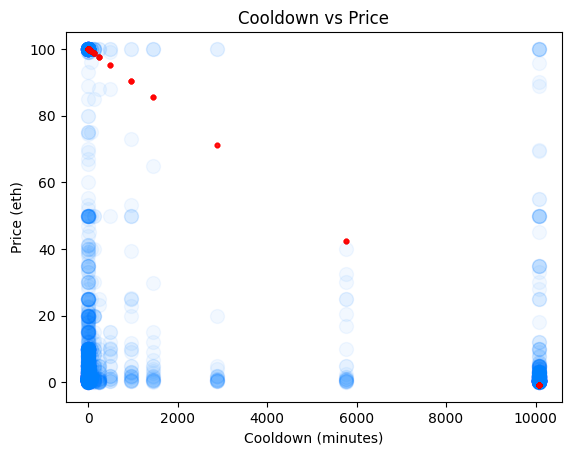

In [14]:
plt.scatter(train_df['clean_speed'], train_df['clean_price'], c=(0, .5, 1, .05), s=100)
plt.scatter(train_df['clean_speed'], train_df['predicted_price'], c=(1, .01, .01, .1), s=10)
plt.title('Cooldown vs Price')
plt.xlabel('Cooldown (minutes)')
plt.ylabel('Price (eth)')
plt.show()

In [15]:
# Now we can calculate something called "loss", or how far away from the right answer we were:
import numpy as np
np.mean(np.abs(train_df['clean_price'] - train_df['predicted_price']))

69.04251355000001

In [16]:
# So on average, we were 69ETH away from the right answer
# This is ~$100k, so not a great prediction, but it's a starting point!
# What if instead of picking a random values for m and b, what if we let an algorithm try out lots of values for them,
# and use the values that produce the lowest error?
# This is the idea behind linear regression!
from sklearn.linear_model import LinearRegression

# Creating our LinearRegression model
lr_model = LinearRegression()

In [17]:
train_df['clean_speed']

0           1
1       10080
2           2
3       10080
4          10
        ...  
1995        1
1996        2
1997        1
1998        1
1999        1
Name: clean_speed, Length: 2000, dtype: int64

In [18]:
lr_model.fit(train_df[['clean_speed']], train_df['clean_price'])

LinearRegression()

In [19]:
train_df['lr_predicted_price'] = lr_model.predict(train_df[['clean_speed']])
train_df['lr_predicted_price']

0       14.375963
1        6.430715
2       14.375175
3        6.430715
4       14.368869
          ...    
1995    14.375963
1996    14.375175
1997    14.375963
1998    14.375963
1999    14.375963
Name: lr_predicted_price, Length: 2000, dtype: float64

/tmp/ipykernel_20/2925529913.py:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(train_df['clean_speed'], train_df['clean_price'], c=(0, .5, 1, .05), s=100)
/tmp/ipykernel_20/2925529913.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(train_df['clean_speed'], train_df['lr_predicted_price'], c=(1, .01, .01, .1), s=10)


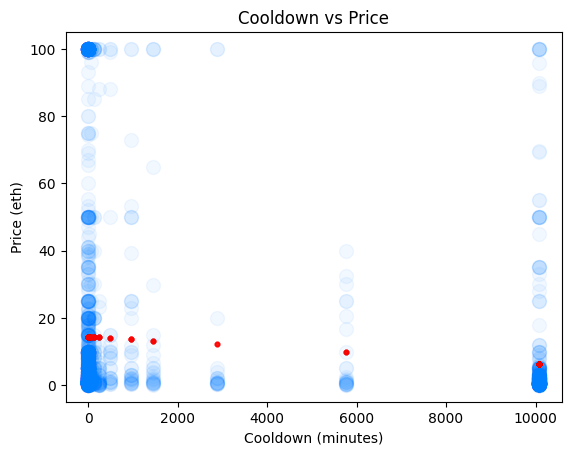

In [20]:
plt.scatter(train_df['clean_speed'], train_df['clean_price'], c=(0, .5, 1, .05), s=100)
plt.scatter(train_df['clean_speed'], train_df['lr_predicted_price'], c=(1, .01, .01, .1), s=10)
plt.title('Cooldown vs Price')
plt.xlabel('Cooldown (minutes)')
plt.ylabel('Price (eth)')
plt.show()

In [21]:
np.mean(np.abs(train_df['clean_price'] - train_df['lr_predicted_price']))

16.568263885615618

In [22]:
test_df

,id,speed,image
0,cb5edc4fbb104b89,Fast (1m),./images/cb5edc4fbb104b89.png
1,1bcef002ce389c49,Slow (24h),./images/1bcef002ce389c49.png
2,bd76ce405ca030f0,Fast (1m),./images/bd76ce405ca030f0.png
3,40553013075ce241,Swift (5m),./images/40553013075ce241.png
4,286049d7edf3ba23,Fast (1m),./images/286049d7edf3ba23.png
...,...,...,...
115,6cf64aa97e47a07b,Catatonic (1w),./images/6cf64aa97e47a07b.png
116,fc6facf81274fc32,Fast (1m),./images/fc6facf81274fc32.png
117,23ce24895ca207a1,Catatonic (1w),./images/23ce24895ca207a1.png
118,64bd0b8e987ac69d,Fast (1m),./images/64bd0b8e987ac69d.png


In [23]:
# Our error went down a ton! It's still not perfect, but we're making progress!
# Let's use this model to make a submission:
test_df['clean_speed'] = test_df['speed'].apply(clean_speed)
test_df['clean_speed'] 

0          1
1       1440
2          1
3          5
4          1
       ...  
115    10080
116        1
117    10080
118        1
119        1
Name: clean_speed, Length: 120, dtype: int64

(array([92.,  3.,  1.,  0.,  0.,  3.,  0.,  0.,  0., 21.]),
 array([1.0000e+00, 1.0089e+03, 2.0168e+03, 3.0247e+03, 4.0326e+03,
        5.0405e+03, 6.0484e+03, 7.0563e+03, 8.0642e+03, 9.0721e+03,
        1.0080e+04]),
 <BarContainer object of 10 artists>)

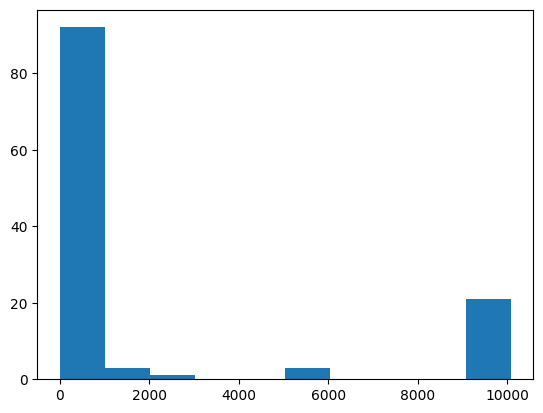

In [24]:
plt.hist(test_df['clean_speed'])

In [25]:
test_df['price'] = lr_model.predict(test_df[['clean_speed']])

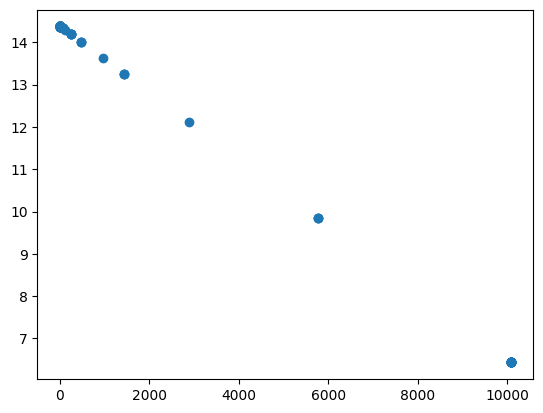

In [26]:
plt.scatter(test_df['clean_speed'], test_df['price'])

# Creating A Model with Square Root of Our Data

In [27]:
train_df['root_clean_speed'] = train_df['clean_speed'] ** 0.5
test_df['root_clean_speed'] = test_df['clean_speed'] ** 0.5

In [28]:
lr_more_features_model = LinearRegression()
lr_more_features_model.fit(train_df[['clean_speed', 'root_clean_speed']], train_df['clean_price'])
train_df['more_features_prediction'] = lr_more_features_model.predict(train_df[['clean_speed', 'root_clean_speed']])

/tmp/ipykernel_20/954843979.py:1: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(train_df['clean_speed'], train_df['clean_price'], c=(0, .5, 1, .05), s=100)
/tmp/ipykernel_20/954843979.py:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(train_df['clean_speed'], train_df['more_features_prediction'], c=(1, .01, .01, .1), s=10)


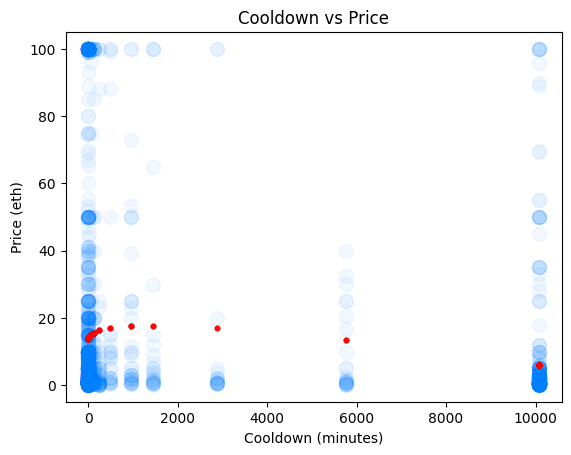

In [29]:
plt.scatter(train_df['clean_speed'], train_df['clean_price'], c=(0, .5, 1, .05), s=100)
plt.scatter(train_df['clean_speed'], train_df['more_features_prediction'], c=(1, .01, .01, .1), s=10)
plt.title('Cooldown vs Price')
plt.xlabel('Cooldown (minutes)')
plt.ylabel('Price (eth)')
plt.show()

In [30]:
test_df['price'] = lr_more_features_model.predict(test_df[['clean_speed', 'root_clean_speed']])

In [31]:
submission_columns = test_df[['id','price']]
submission_columns.to_csv('submission.csv', index=False)